In [1]:
library(rethinking)

Loading required package: parallel

rethinking (Version 2.13.2)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [2]:
library(dagitty)

# Chapter 7

## Ulisses' Compass
Regularization and predictive accuracy

Statistical model design needs us to navigate through


- <font color="red">overfitting</font>
- <font color="red">underfitting</font>
- <font color="red">confounding (chapter 6)</font>


How do I **define and evaluate** a model managing **regular/irregular features**?

Do I need to **predict** or want to **understand causal structure**?

More parameters (predictors) **generally improve fit** (the variance explained).
<img src="./img/increasingR.png" alt="Drawing" style="width: 500px;"/>


But less parameters can be a problem (Leave-One-Out models give differing posteriors)
<img src="./img/LOOunderfit.png" alt="Drawing" style="width: 500px;"/>


## Measuring the model accuracy

Based on information theory - the **measure of statistic uncertainty** of using some distributions to model the unknown distribution of observations

**Entropy** (average log-prob of an event) is continuous, increases with num. of events and is additive

$$ H(p) = -\pmb E log(p) = -\sum_{i=1}^N p_i log(p_i)$$

**KL divergence** compares a modeling distribution q with the target distribution p. It is NOT symmetric (Mars-Earth and Earth-Mars example).

$$ D_{KL}(q,p) = \sum_i p_i log\Big (\frac{p_i}{q_i}\Big ) $$

**KL-divergence** is the difference between 
- the cross entropy $H(p,q)$ (where events arising with their target probability are expected with a model distribution) 
- the actual entropy $H(p)$ (describing the target distribution of the data)

In real life the **target is unknown**, but 

$$ D_{KL}(q,p)-D_{KL}(r,p) = \pmb E_plog(r)-E_plog(q) \propto \sum_i \log(r_i) - \sum_i \log(q_i) =: S(r) - \pmb S(q) $$

so two candidate distributions can be compared to **know relatively the divergence from p (deviance)**.

### In practice:

- $r,q$ are posteriors
- for each observation, there is (are) a posterior distribution(s), for which you need parameters' samples
- for each $i$, average the posterior distribution linked to observation $i$ (lppd) and marginal posterior samples $s$
$$ lppd(y,\Theta) = \sum_i \log \frac{1}{N} \sum_n p(y_i|\theta_n)$$
- ideally you train on a training set, but score on a test set

Brain volume as a function of body mass - linear model

\begin{align*}
&b_i \sim \mathcal N(\mu_i,\sigma); \quad\mu_i = \alpha + \beta m_i \\
&\alpha \sim \mathcal N(.5, 1); \quad\beta \sim \mathcal N(0,10); \quad\alpha \sim \ln \mathcal N(0,1)\\
\end{align*}

In [ ]:
## Create dataset
sppnames <- c( "afarensis","africanus","habilis","boisei", "rudolfensis","ergaster","sapiens") #homus list
brainvolcc <- c( 438 , 452 , 612, 521, 752, 871, 1350 ) #cc of brain volume
masskg <- c( 37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 ) #kg mass
d <- data.frame( species=sppnames , brain=brainvolcc , mass=masskg )
## Standardize
d$mass_std <- (d$mass - mean(d$mass))/sd(d$mass) 
d$brain_std <- d$brain / max(d$brain)

In [5]:
m7.1 <- quap( alist( brain_std ~ dnorm( mu , exp(log_sigma) ), 
                     mu <- a + b*mass_std,
                     a ~ dnorm( 0.5 , 1 ),
                     b ~ dnorm( 0 , 10 ),
                     log_sigma ~ dnorm( 0 , 1 ) ), data=d )

In [6]:
R2_is_bad <- function( quap_fit ) { s <- sim( quap_fit , refresh=0 ) 
                                    r <- apply(s,2,mean) - d$brain_std 
                                    1 - var2(r)/var2(d$brain_std) }

In [12]:
R2=R2_is_bad(m7.1)

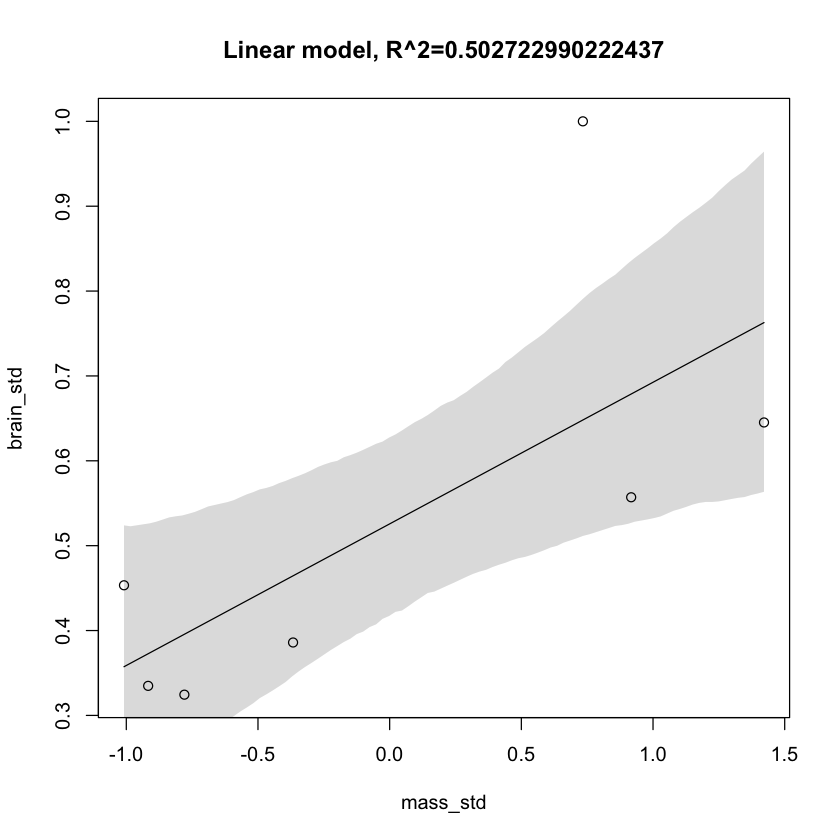

In [18]:
post <- extract.samples(m7.1) #extract marginal posteriors
mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 ) #grid input
#calculate model values using posteriors for EACH value of the grid
l <- link( m7.1 , data=list( mass_std=mass_seq ) )
#brain volume posterior mean and CI for each grid value
mu <- apply( l , 2 , mean ); ci <- apply( l , 2 , PI )

plot( brain_std ~ mass_std , data=d, main=paste('Linear model, R^2=',as.character(R2),sep=''))
lines( mass_seq , mu )
shade( ci , mass_seq )

### Calculate $ lppd(y,\Theta) = \sum_i \log \frac{1}{N} \sum_n p(y_i|\theta_n)$

In [39]:
set.seed(1); lppd( m7.1 , n=1e4 )

[1]  0.6098670  0.6483440  0.5496092  0.6234936  0.4648145  0.4347607 -0.8444639

That is

In [37]:
logprob <- sim( m7.1 , ll=TRUE , n=1e4 ) #simulate 10000 posteriors for each data point
n <- ncol(logprob); ns <- nrow(logprob)
f <- function( i ) log_sum_exp( logprob[,i] ) - log(ns) 
( lppd <- sapply( 1:n , f ) )

[1]  0.6130167  0.6511801  0.5446837  0.6268520  0.4631037  0.4287143 -0.8619043

## Regularizing priors

Changing the **prior's confidence w.r.t your data** changes the fit over regular/irregular features. 

Less conservative priors allow for more variation of the observed outcome.
<img src="./img/regPrior.png" alt="Drawing" style="width: 300px;"/>

The **quantity of data available** will influence the effect of regularization (blue=training, black=out of sample)

Regularizing is especially good with limited data size.

<img src="./img/dataEffectRegul.png" alt="Drawing" style="width: 600px;"/>

## Accuracy prediction

If you do not have an out of sample test set, you can resort to predicting your accuracy. There are various strategies:

- **Cross-validation**. For example LOOCV (leave one out cross validation): **average over LPPDs** removing a datapoint at a time 
    - LOOCV leads to **PSIS (Pareto) approximation**
    - The Pareto parameter $k$ gives **reliability of the approximation** ($k<0.5$ or $k<.7$ for reliable approximation)


- Information criteria: **estimate of relative KL divergence**. AIC has a term increasing with twice the num. of parameter (in linear models).
    $$AIC = -2 * LPPD + 2|\theta|$$ 

**AIC** needs some **restrictive assumptions** on likelihood>>priors, N>>p, gaussian posterior at infinite N.

**WAIC** relaxes those assumptions. It includes a **more complicated penalty term**:
 
- $$WAIC(y,\Theta) = -2\Big(lppd -\sum_i var_\theta \log p(y_i|\theta)\Big) = -2\Big(lppd - \sum_i \lambda_i\Big)$$

- standard error (from CLT): $$ s_{WAIC} = \sqrt{ N \cdot var \big(lppd - [\lambda_1,\dots,\lambda_N]\big)} $$

**IMPORTANT**: CV and Information criteria are **calculated pointwise**, so you can study the effect of single datapoints on penalty, PSIS's parameter k, ...

Predicting the true accuracy
<img src="./img/regulCompare copy.png" alt="Drawing" style="width: 700px;"/>

### Example: fungal treatment (Chpt 6)


Information Criteria are **<font color="green">FOR prediction</font>**, **<font color="red">NOT Causality</font>**

In [41]:
set.seed(71)
# number of plants 
N <- 100
# simulate initial heights 
h0 <- rnorm(N,10,2)
# assign treatments and simulate fungus and growth 
treatment <- rep( 0:1 , each=N/2 )
fungus <- rbinom( N , size=1 , prob=0.5 - treatment*0.4 ) 
h1 <- h0 + rnorm(N, 5 - 3*fungus)
# compose a clean data frame
d <- data.frame( h0=h0 , h1=h1 , treatment=treatment , fungus=fungus ) 
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


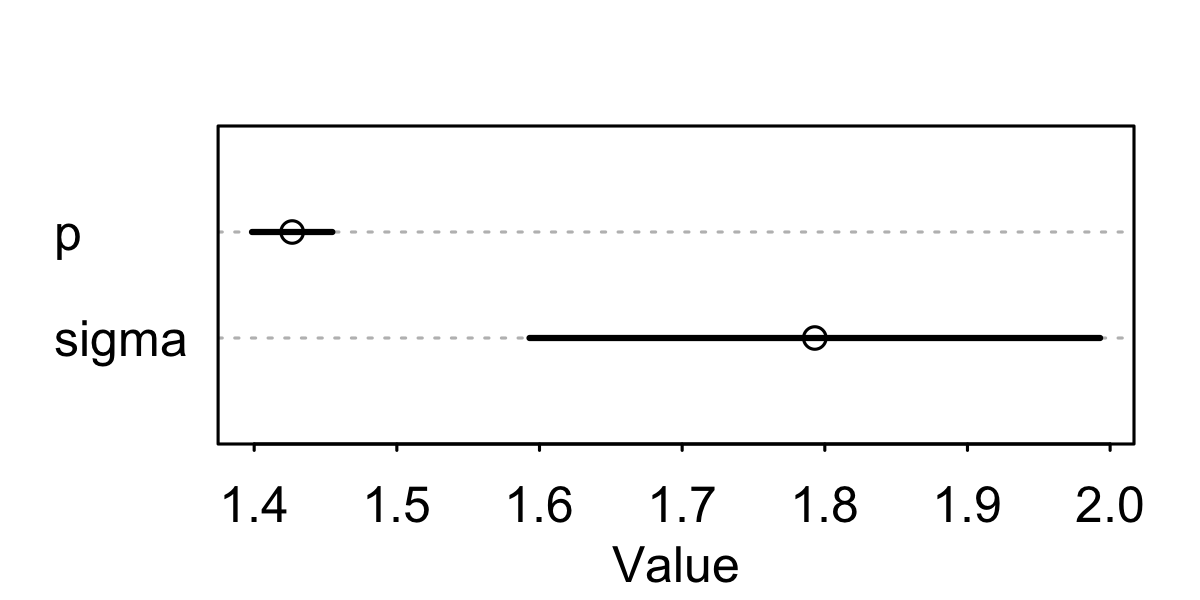

In [48]:
growth <- quap( alist(
        h1 ~ dnorm( mu , sigma ), 
        mu <- h0*p,
        p ~ dlnorm( 0 , 0.25 ), sigma ~ dexp( 1 )), 
        data=d ) 
options(repr.plot.width=4, repr.plot.height=2, repr.plot.res = 300) #resize plots
plot(precis(growth))

In [49]:
treat_fungi <- quap( alist(
            h1 ~ dnorm( mu , sigma ),
            mu <- h0 * p,
            p <- a + bt*treatment + bf*fungus, 
            a ~ dlnorm( 0 , 0.2 ) , bt ~ dnorm( 0 , 0.5 ), bf ~ dnorm( 0 , 0.5 ),
            sigma ~ dexp( 1 )), 
            data=d ) 
precis(treat_fungi)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481390625,0.02451064,1.44221788,1.52056337
bt,0.002413196,0.02986959,-0.04532418,0.05015057
bf,-0.266718089,0.03654765,-0.32512829,-0.20830789
sigma,1.408794484,0.09862019,1.25118037,1.56640860


In [50]:
treat <- quap( alist(
            h1 ~ dnorm( mu , sigma ),
            mu <- h0 * p,
            p <- a + bt*treatment, 
            a ~ dlnorm( 0 , 0.2 ) , bt ~ dnorm( 0 , 0.5 ),
            sigma ~ dexp( 1 )), 
            data=d ) 
precis(treat)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.38035050,0.02517689,1.34011297,1.4205880
bt,0.08499642,0.03429897,0.03018004,0.1398128
sigma,1.74640906,0.12193162,1.55153879,1.9412793


Better WAIC including all predictors

In [51]:
set.seed(11) 
WAIC( treat_fungi )

WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
361.4511,-177.1724,3.553208,14.1704


In [52]:
set.seed(77)
compare( growth , treat_fungi , treat )

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
treat_fungi,361.8901,14.26196,0.00000,NA,3.839503,1.000000e+00
treat,402.7753,11.28130,40.88520,10.47816,2.645609,1.324010e-09
growth,405.9147,11.65023,44.02462,12.22698,1.581705,2.755335e-10


In [55]:
set.seed(91)
waic_treatfungi <- WAIC( treat_fungi , pointwise=TRUE )$WAIC 
waic_treat <- WAIC( treat , pointwise=TRUE )$WAIC 
n <- length(waic_treatfungi)
diff_treatfungi_treat <- waic_treatfungi - waic_treat
sqrt( n*var( diff_treatfungi_treat ) )

[1] 10.35788

Differences from the best model have large WAIC standard error

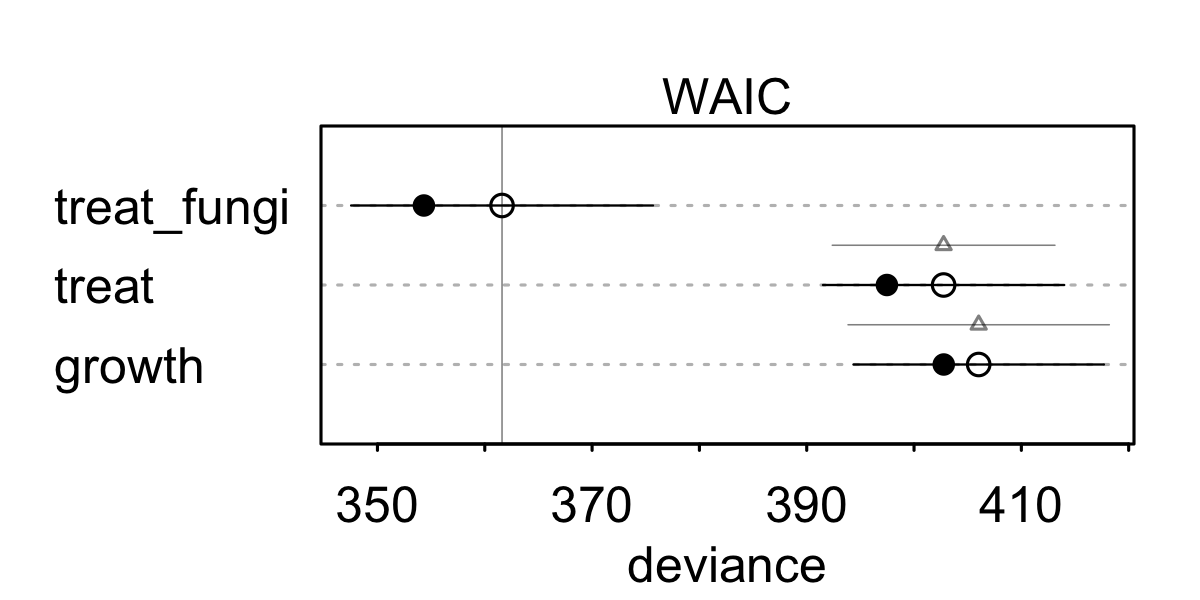

In [56]:
#white dot=WAIC, black dot=deviance, gray line= SD(difference)
plot( compare( growth , treat_fungi , treat ) )

Same holds for PSIS. It gives no warnings about k in this model.

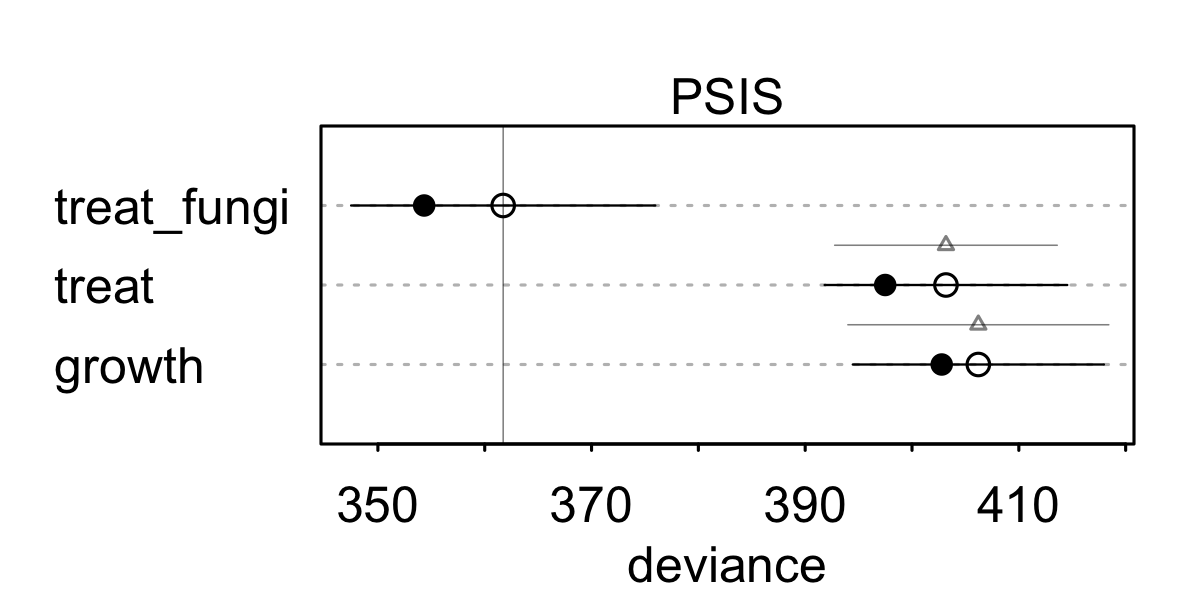

In [57]:
plot( compare( growth , treat_fungi , treat, func = 'PSIS' ) )

In [59]:
set.seed(92)
#waic_growth <- WAIC( growth , pointwise=TRUE )$WAIC 
#diff_growth_treat <- waic_growth - waic_treat
#sqrt( n*var( diff_growth_treat ) )
compare( growth , treat_fungi , treat )@dSE

,growth,treat_fungi,treat
growth,NA,12.23192,4.941351
treat_fungi,12.231923,NA,10.440008
treat,4.941351,10.44001,NA


- WAIC and PSIS are useful for prediction

- do not select the best model, but compare differences.

    - what model is best? 
    - how much difference there is?
    - which points are influencing the result?
    
- Again, the most realistic model is not necessarily the best one

### Example: waffle houses and divorces


Model complexity and outliers

In [231]:
library(rethinking) 
data(WaffleDivorce) 
d <- WaffleDivorce 
d$A <- standardize( d$MedianAgeMarriage )
d$D <- standardize( d$Divorce )
d$M <- standardize( d$Marriage )

age <- quap( alist( D ~ dnorm( mu , sigma ) , 
                    mu <- a + bA * A ,
                    a ~ dnorm( 0 , 0.2 ) , bA ~ dnorm( 0 , 0.5 ) , 
                    sigma ~ dexp( 1 ) ) , data = d )

marRate <- quap( alist( D ~ dnorm( mu , sigma ) ,
                        mu <- a + bM * M ,
                        a ~ dnorm( 0 , 0.2 ) , bM ~ dnorm( 0 , 0.5 ) , 
                        sigma ~ dexp( 1 ) ) , data = d )

age_marRate <- quap( alist( D ~ dnorm( mu , sigma ) , 
                            mu <- a + bM*M + bA*A , 
                            a ~ dnorm( 0 , 0.2 ) , 
                            bM ~ dnorm( 0 , 0.5 ) , bA ~ dnorm( 0 , 0.5 ) , 
                            sigma ~ dexp( 1 )) , data = d )

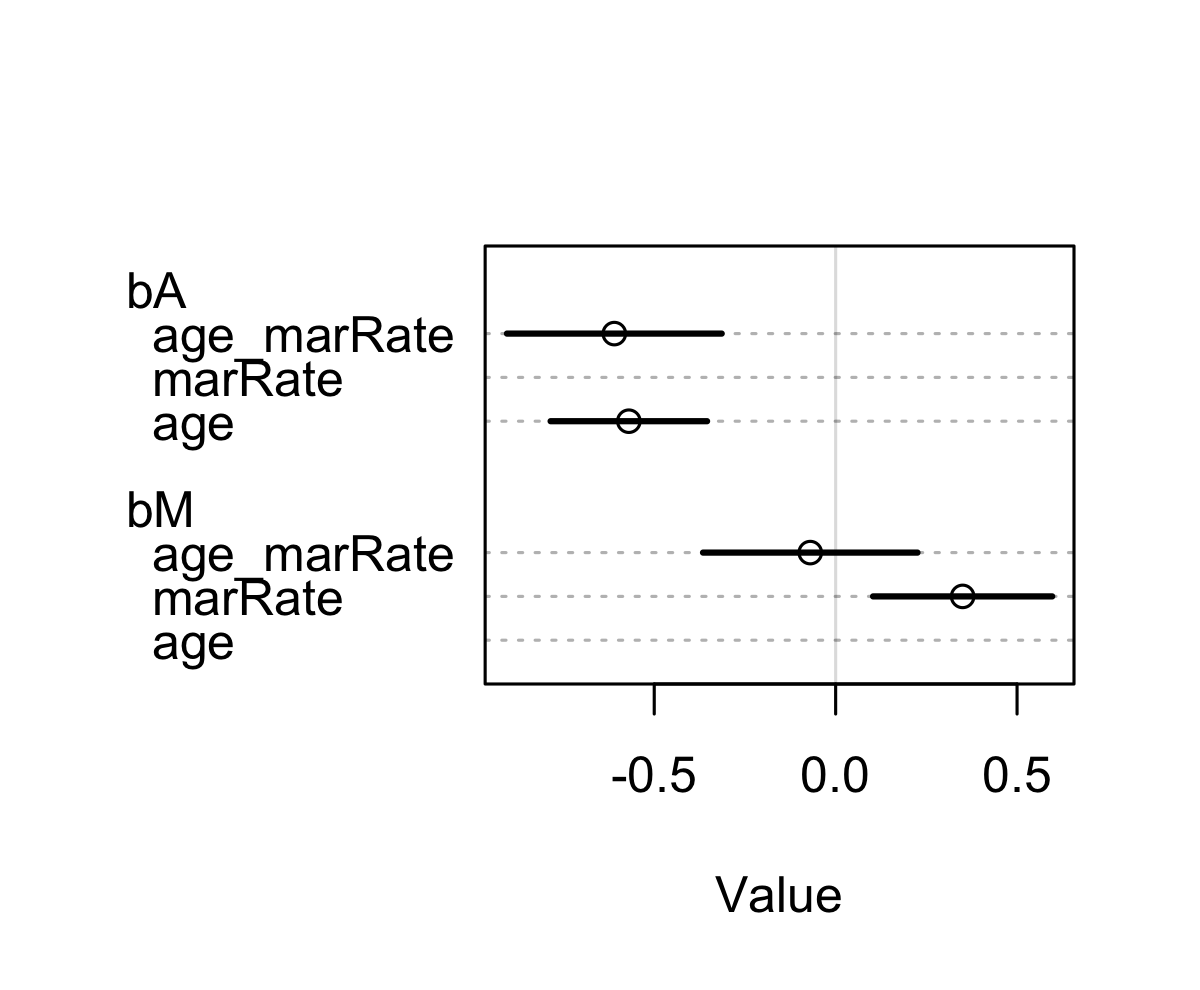

In [233]:
options(repr.plot.width=4, repr.plot.height=3.3, repr.plot.res = 300) #resize plots
plot( coeftab(age, marRate, age_marRate), par=c('bA','bM') )

PSIS detects anomalies. Some approximations have infinite variance. The age-based model seems the best (as it was in the causal model)

In [73]:
compare( age , marRate , age_marRate , func=PSIS )

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,127.2787,14.52577,0.000000,NA,4.576489,0.7961139822
age_marRate,130.0116,15.47129,2.732934,1.298906,6.227212,0.2030140637
marRate,140.9122,11.28144,13.633522,10.671833,3.897346,0.0008719541


Some points have both high WAIC penalty and high PSIS-k 

In [ ]:
set.seed(24071847)
PSIS_ageMarRate <- PSIS(age_marRate,pointwise=TRUE)
set.seed(24071847)
WAIC_ageMarRate <- WAIC(age_marRate,pointwise=TRUE)
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



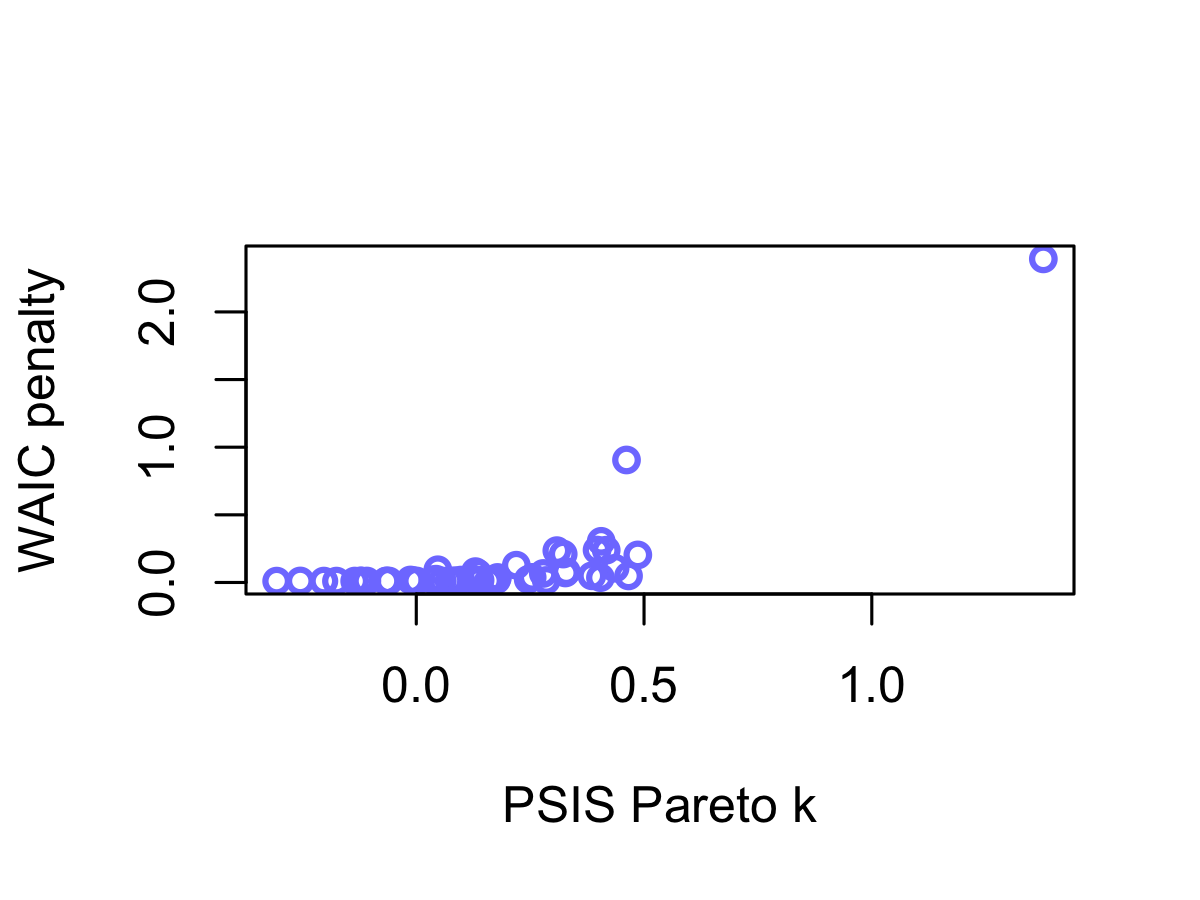

In [78]:
plot( PSIS_ageMarRate$k , WAIC_ageMarRate$penalty , xlab="PSIS Pareto k" ,
    ylab="WAIC penalty" , col=rangi2 , lwd=2 )

The penalty comes from too much variance: the prediction curve swings a lot to overfit the outliers. Note that the penalty term is 3 times the number of parameters in the age + marriage rate model!

In [79]:
WAIC(age_marRate)

WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
128.4831,-58.79194,5.449622,14.35516



We can regularize with a Student's t distribution with heavier tails

In [82]:
age_marRate_t <- quap( alist( D ~ dstudent( 2 , mu , sigma ) , 
                              mu <- a + bM*M + bA*A ,
                              a ~ dnorm( 0 , 0.2 ) ,
                              bM ~ dnorm( 0 , 0.5 ) , bA ~ dnorm( 0 , 0.5 ) ,
                              sigma ~ dexp( 1 ) ) , data = d )
PSIS(age_marRate_t)

PSIS,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
134.0506,-67.02531,7.0702,11.91619


More deviance and higher WAIC

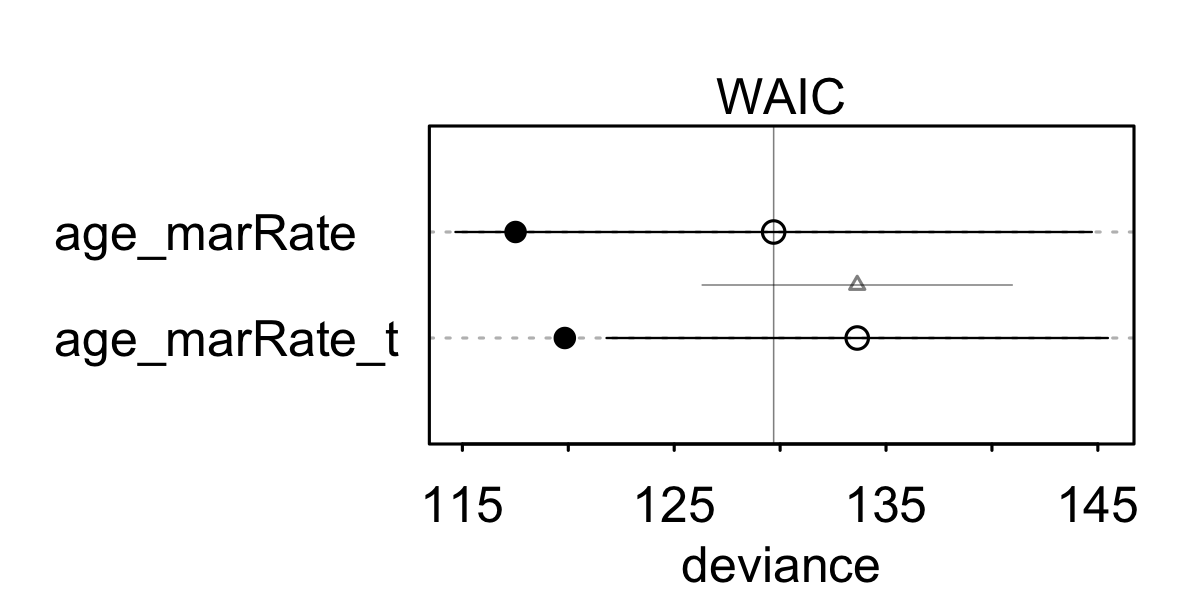

In [236]:
options(repr.plot.width=4, repr.plot.height=2, repr.plot.res = 300)
plot(compare(age_marRate_t,age_marRate))

a bit higher penalty (more variance from the t distribution) but lower standard error in WAIC

In [238]:
compare(age_marRate_t,age_marRate)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age_marRate,129.0269,14.35271,0.000000,NA,5.705529,0.93617699
age_marRate_t,134.3983,11.80654,5.371382,6.840711,7.291571,0.06382301


No warning in PSIS for the regularized model.

In [240]:
compare(age_marRate_t,age_marRate, func = 'PSIS')

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age_marRate,129.2865,15.11381,0.000000,NA,5.868607,0.8904523
age_marRate_t,133.4772,11.92755,4.190739,7.349959,6.811609,0.1095477


## Exercise: Handdrawn curve and outliers
<img src="./img/7H1.png" alt="Drawing" style="width: 1000px;"/>

In [91]:
data(Laffer)
head(Laffer)

,tax_rate,tax_revenue
,<dbl>,<dbl>
1,0.07,-0.06
2,8.81,2.45
3,12.84,3.58
4,16.24,2.19
5,19.18,2.46
6,19.29,1.95


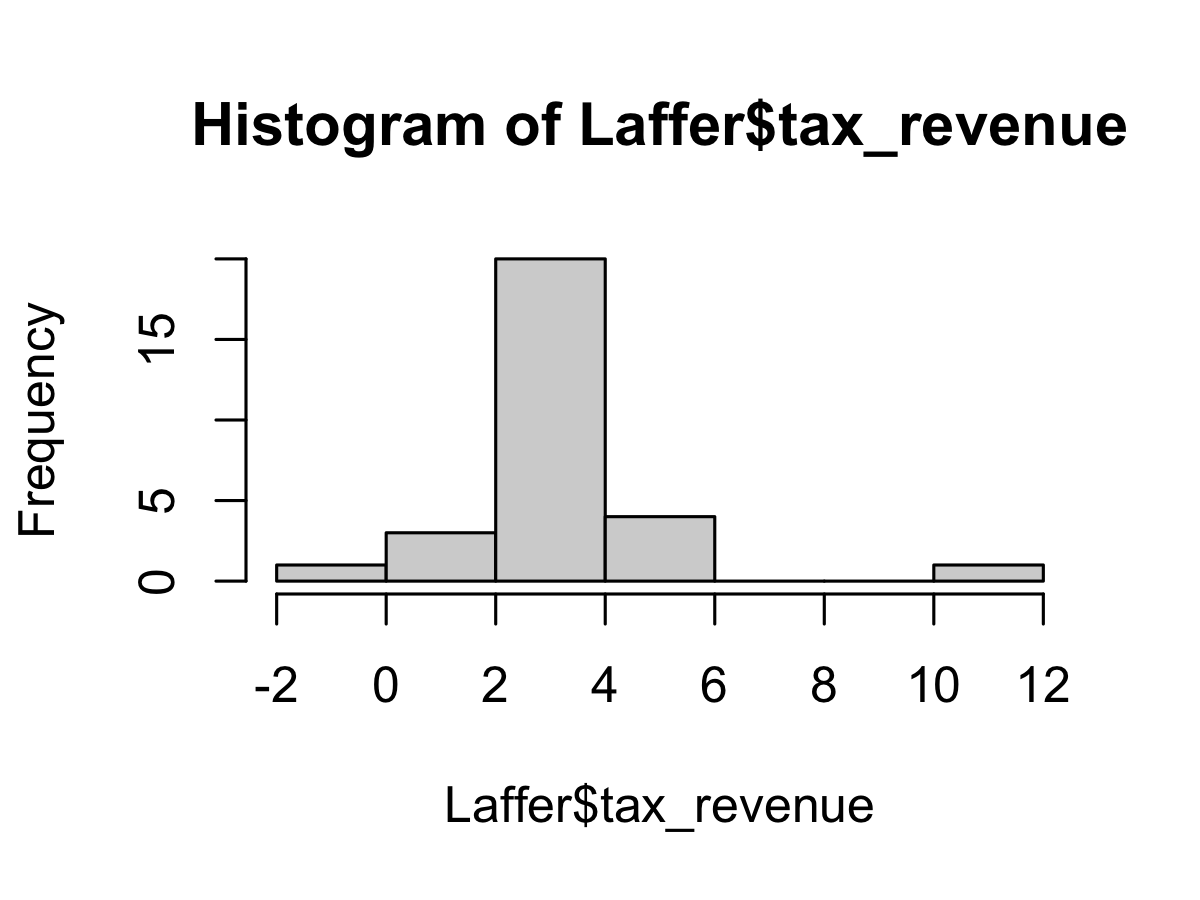

In [100]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)
hist(Laffer$tax_revenue)

Standardize the rate, keep the revenue as it is.

In [241]:
d <- data.frame(rate = Laffer$tax_rate/max(Laffer$tax_rate),
                revenue = Laffer$tax_revenue)
head(d)

,rate,revenue
,<dbl>,<dbl>
1,0.001975727,-0.06
2,0.248659328,2.45
3,0.362404742,3.58
4,0.458368614,2.19
5,0.541349139,2.46
6,0.544453853,1.95


## Unregularized modeling

linear, quadratic and cubic regression of the revenue's mean

In [242]:
m.line <- quap( alist( revenue ~ dnorm(mu , sigma ), 
                              mu <- a + Brate*rate ,
                              a ~ dnorm( 0 , 100 ) ,
                              Brate ~ dnorm( 0.5 , 1 ),
                              sigma ~ dexp( 1 ) ) , data = d )
options(repr.plot.width=4, repr.plot.height=1.5, repr.plot.res = 300)

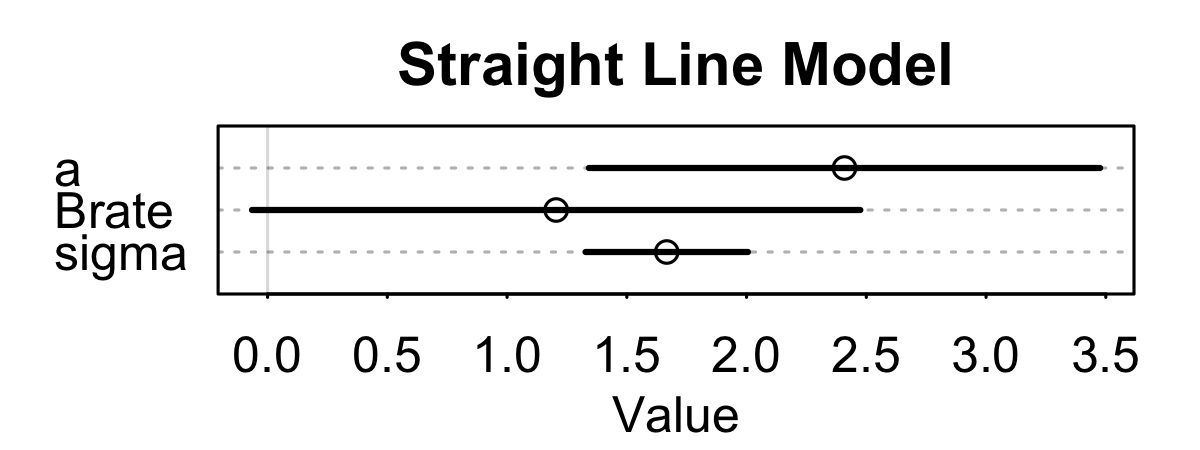

In [243]:
plot(precis(m.line), main='Straight Line Model')

In [255]:
m.quad <- quap( alist( revenue ~ dnorm(mu , sigma ) , 
                              mu <- a + Brate*rate + B2rate*rate^2 ,
                              a ~ dnorm( 0 , 100 ) ,
                              Brate ~ dnorm( 0, 10 ), B2rate ~ dnorm( 0, 10 ),
                              sigma ~ dexp( 1 ) ) , data = d )

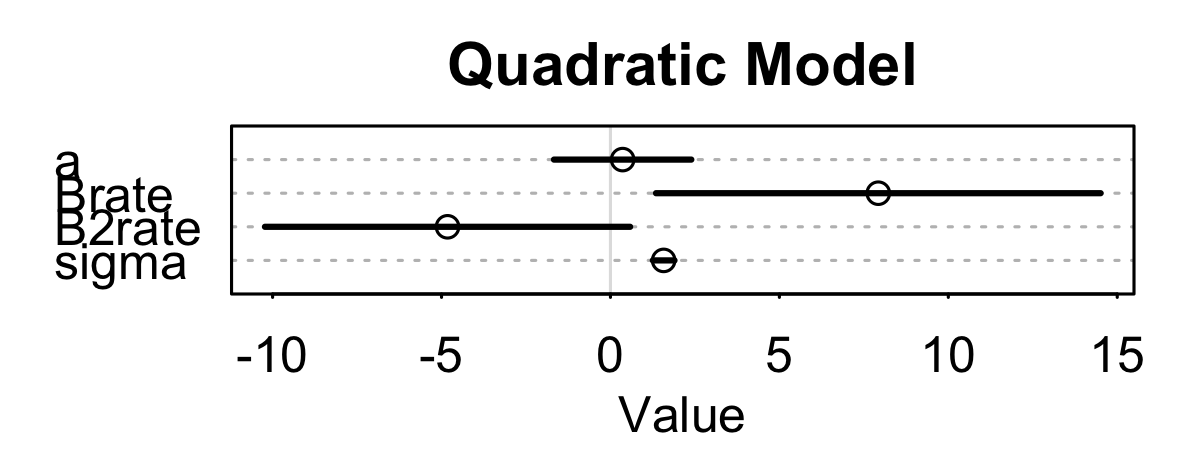

In [256]:
plot(precis(m.quad), main='Quadratic Model')

In [259]:
m.cubic <- quap( alist( revenue ~ dnorm(mu , sigma ) , 
                              mu <- a + Brate*rate + B2rate*rate^3 + B2rate*rate^3 ,
                              a ~ dnorm( 0 , 100 ) ,
                              Brate ~ dnorm( 5, 10 ), B2rate ~ dnorm( -5, 10 ),
                              B3rate ~ dnorm( 5, 10 ), sigma ~ dexp( 1 ) ) , data = d )

The cubic model is especially overfitting, trying to adapt to outliers with the third degree variable

In [ ]:
options(repr.plot.width=4, repr.plot.height=1.8, repr.plot.res = 300)

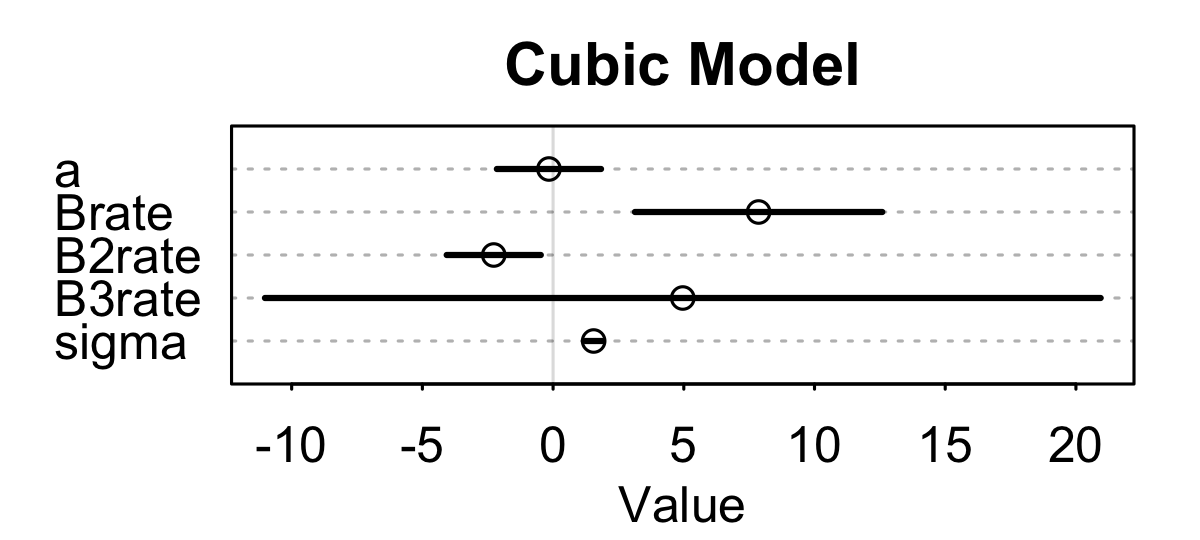

In [261]:
plot(precis(m.cubic), main='Cubic Model')

## Information criteria

WAIC has high penalties and very high standard errors, without any model having much higher performance than the other

In [263]:
compare( m.line, m.quad, m.cubic)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m.line,124.2333,22.80994,0.0000000,NA,6.155154,0.4656998
m.cubic,124.8466,25.06759,0.6132662,3.627020,8.080318,0.3427181
m.quad,126.0097,26.35443,1.7764500,4.305324,8.334508,0.1915821


PSIS-k produce warningswith $k>1$. Again, high penalties (more than $2*parameters$), large errors and equally performing PSIS values

In [266]:
compare( m.line, m.quad, m.cubic , func=PSIS )

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m.cubic,126.2312,26.74120,0.000000,NA,8.831105,0.693123138
m.quad,127.9152,28.64675,1.683920,2.153615,9.247977,0.298642656
m.line,135.0971,33.74315,8.865821,7.582962,11.668193,0.008234206


Which points are problematic in WAIC's penalty vs PSIS-k?

In [267]:
set.seed(1)
PSIS_line <- PSIS(m.line, pointwise=TRUE)
PSIS_quad <- PSIS(m.quad, pointwise=TRUE)
PSIS_cubic <- PSIS(m.cubic, pointwise=TRUE)
set.seed(1)
WAIC_line <- WAIC(m.line, pointwise=TRUE)
WAIC_quad <- WAIC(m.quad, pointwise=TRUE)
WAIC_cubic <- WAIC(m.cubic, pointwise=TRUE)

options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)




Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



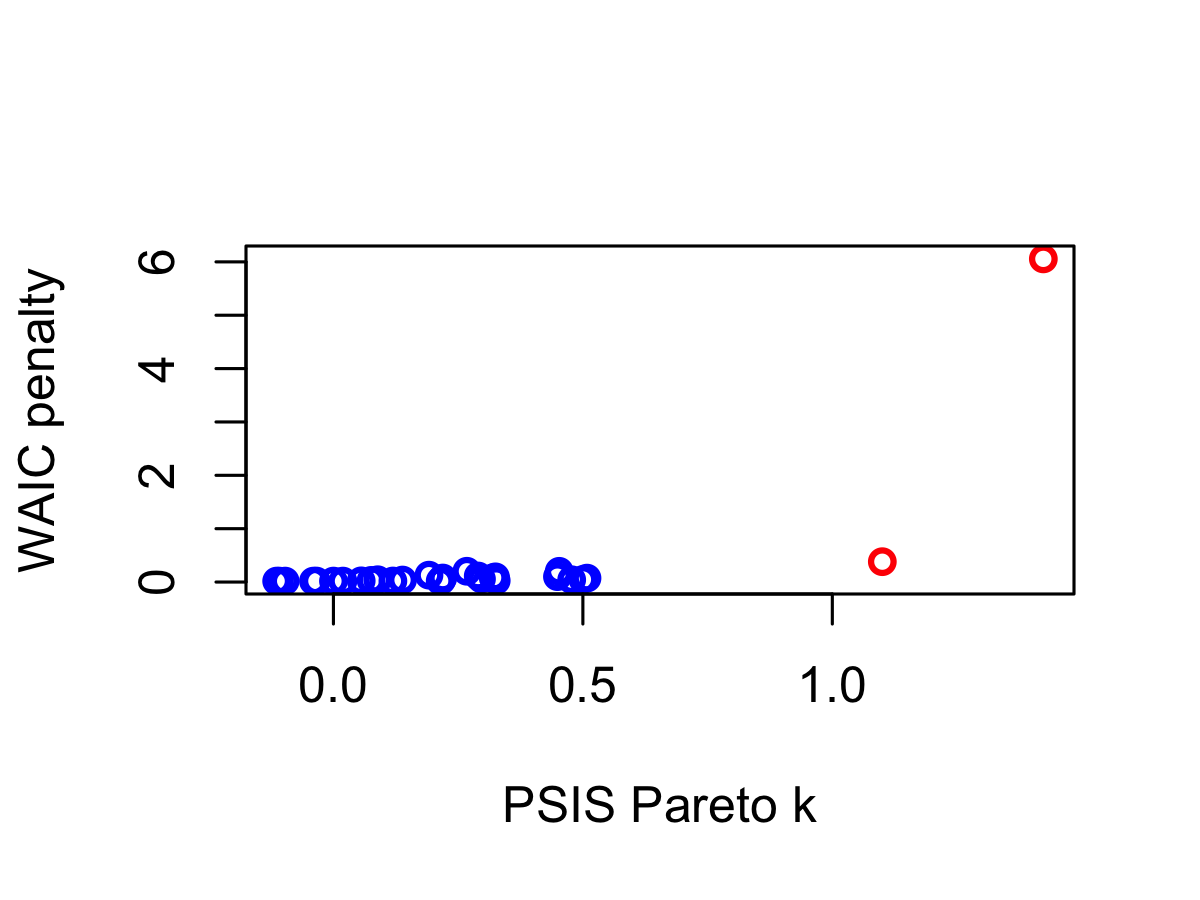

In [268]:
plot( PSIS_quad$k , WAIC_quad$penalty , 
      xlab="PSIS Pareto k", ylab="WAIC penalty", 
      col=ifelse(PSIS_quad$k>=1, 'red', 'blue') , lwd=2 )

Related problematic datapoints for PSIS-k values

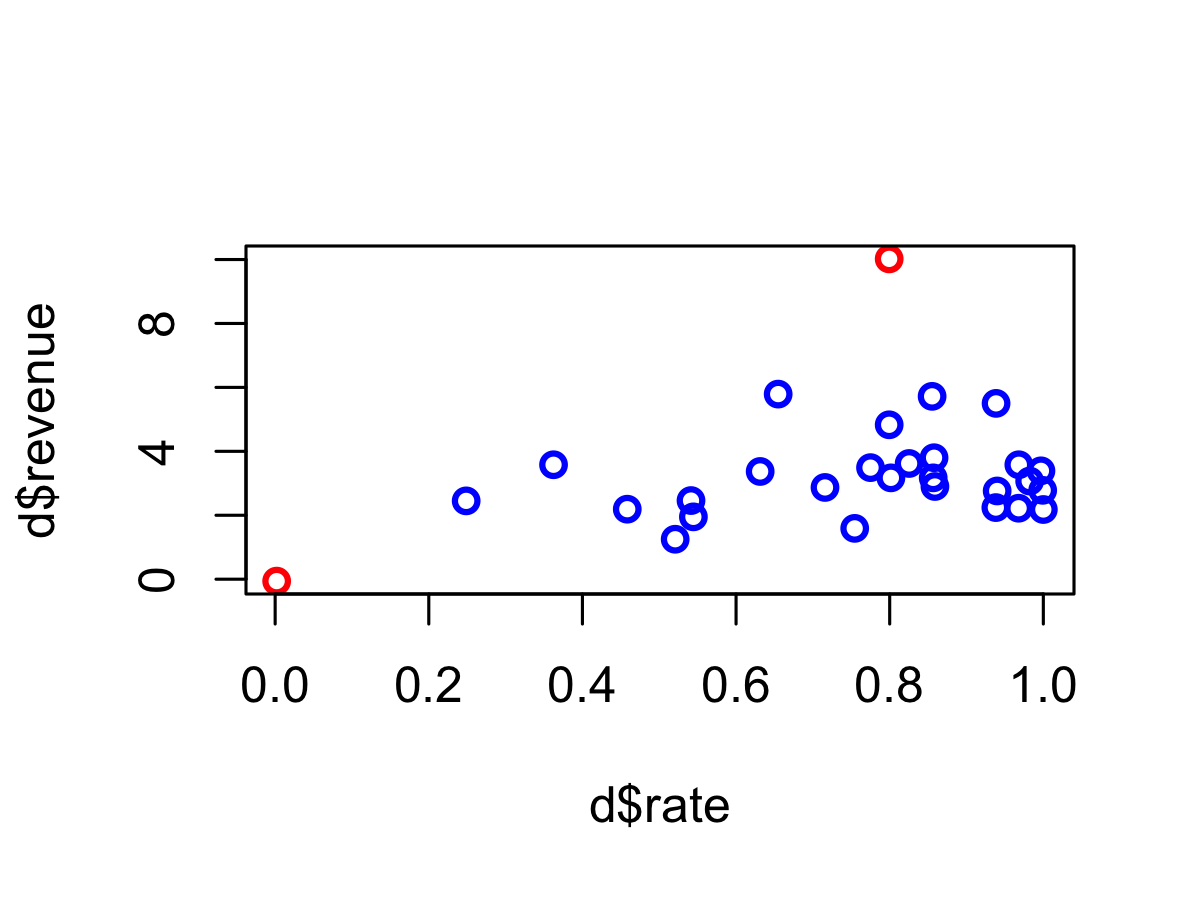

In [269]:
plot(d$revenue ~ d$rate ,
     col=ifelse(PSIS_quad$k>=1, 'red', 'blue') , lwd=2,
     )

Changing revenues from gaussian to student's t-distributed

In [270]:
m.line.T <- quap( alist( revenue ~ dstudent(1.5, mu , sigma ), 
                              mu <- a + Brate*rate ,
                              a ~ dnorm( 0 , 100 ) ,
                              Brate ~ dnorm( 0.5 , 1 ),
                              sigma ~ dexp( 1 ) ) , data = d )

In [271]:
m.quad.T <- quap( alist( revenue ~ dstudent(1.5, mu , sigma ) , 
                              mu <- a + Brate*rate + B2rate*rate^2 ,
                              a ~ dnorm( 0 , 100 ) ,
                              Brate ~ dnorm( 0, 10 ), B2rate ~ dnorm( 0, 10 ),
                              sigma ~ dexp( 1 ) ) , data = d )

In [272]:
m.cubic.T <- quap( alist( revenue ~ dstudent(1.5, mu , sigma ) , 
                              mu <- a + Brate*rate + B2rate*rate^3 + B2rate*rate^3 ,
                              a ~ dnorm( 0 , 100 ) ,
                              Brate ~ dnorm( 5, 10 ), B2rate ~ dnorm( -5, 10 ),
                              B3rate ~ dnorm( 5, 10 ), sigma ~ dexp( 1 ) ) , data = d )

In [273]:
compare( m.quad, m.quad.T)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m.quad.T,105.6123,13.61971,0.00000,NA,3.981181,0.9999465536
m.quad,125.2858,25.68557,19.67356,18.41511,7.953813,0.0000534464


No more problems with PSIS-k

In [275]:
compare( m.quad, m.quad.T, func='PSIS')

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m.quad.T,106.0657,13.80702,0.00000,NA,4.24452,9.999981e-01
m.quad,132.3979,32.43819,26.33216,24.33996,11.43673,1.914446e-06


Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



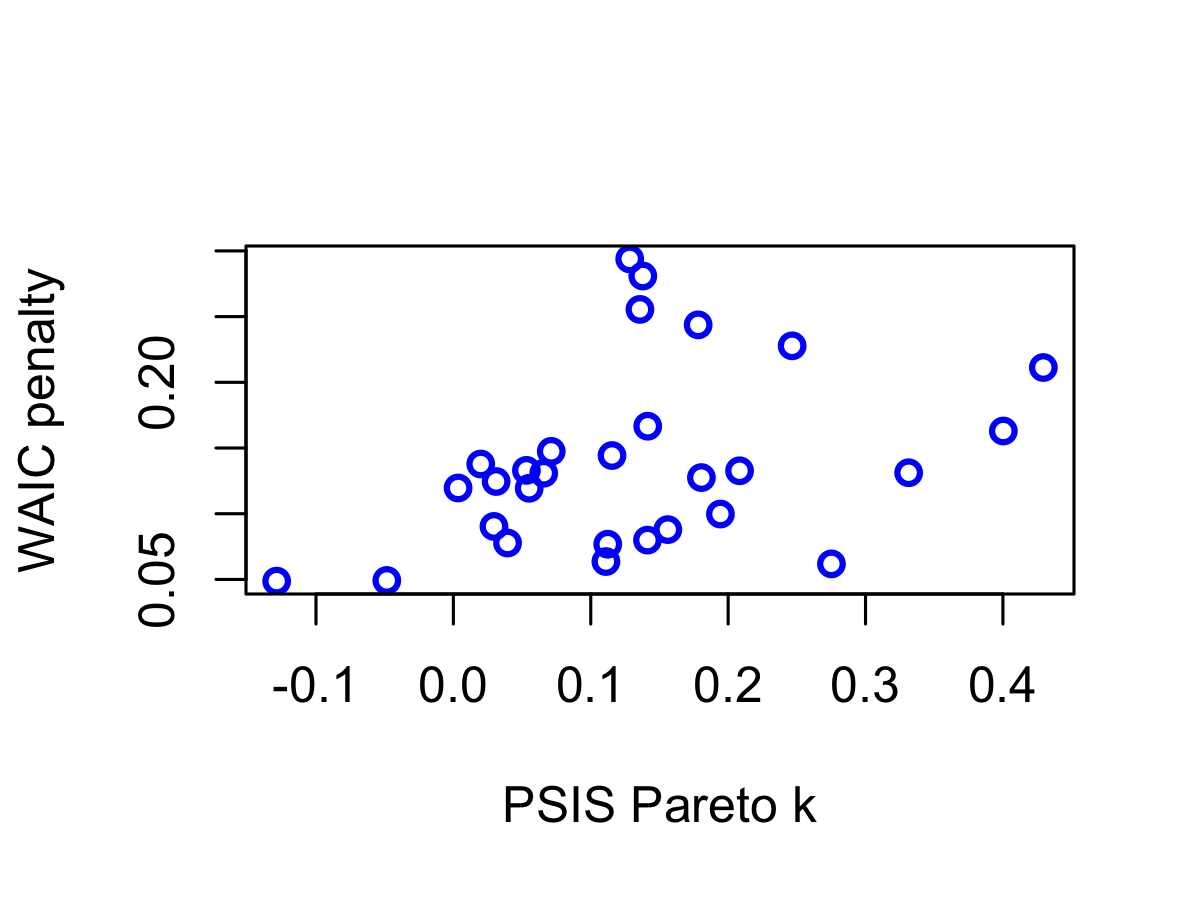

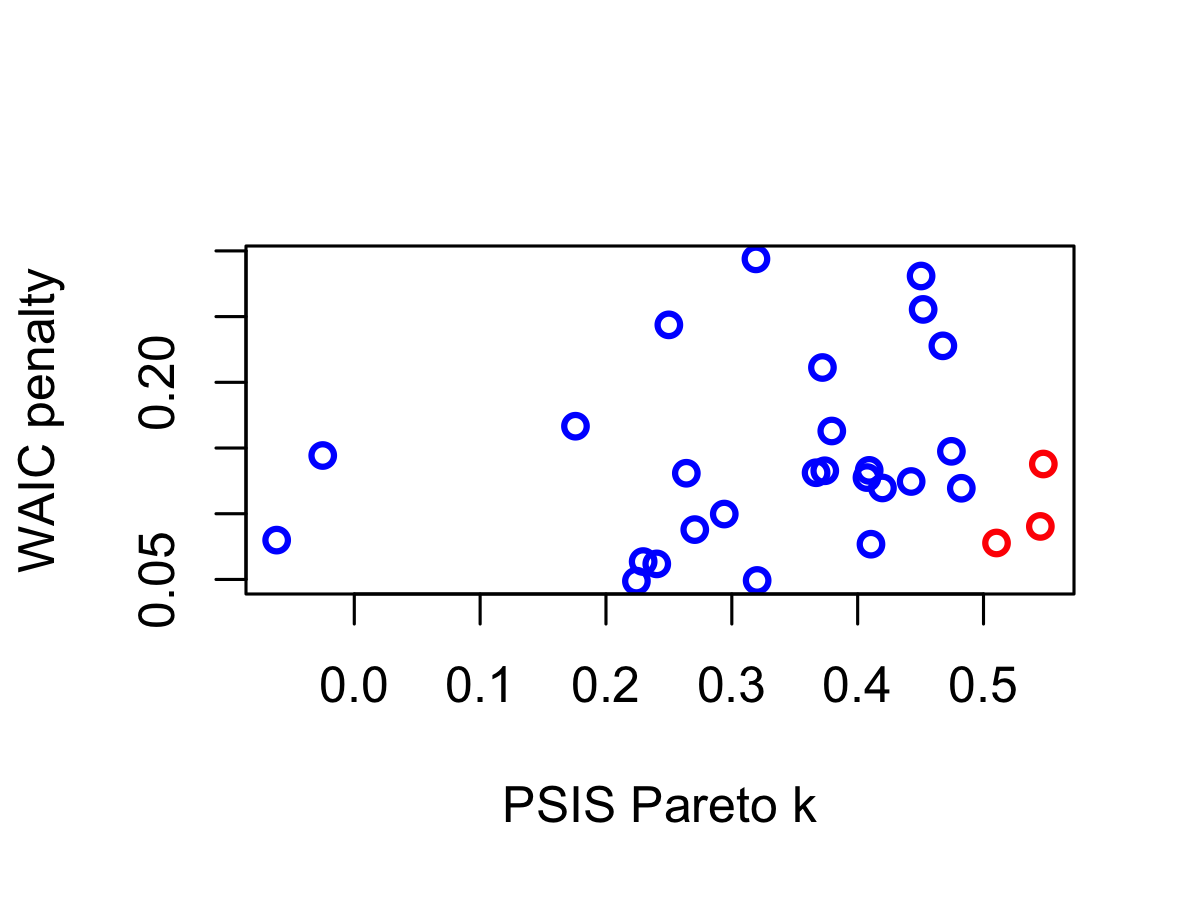

In [276]:
#plot problematic points for t-distributed revenues
set.seed(2)
PSIS_line.T <- PSIS(m.line.T, pointwise=TRUE)
PSIS_quad.T <- PSIS(m.quad.T, pointwise=TRUE)
PSIS_cubic.T <- PSIS(m.cubic.T, pointwise=TRUE)
set.seed(2)
WAIC_line.T <- WAIC(m.line.T, pointwise=TRUE)
WAIC_quad.T <- WAIC(m.quad.T, pointwise=TRUE)
WAIC_cubic.T <- WAIC(m.cubic.T, pointwise=TRUE)

options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)

plot( PSIS_quad.T$k , WAIC_quad.T$penalty , 
      xlab="PSIS Pareto k", ylab="WAIC penalty", 
      col=ifelse(PSIS_quad.T$k>=1, 'red', 'blue') , lwd=2 )
plot( PSIS_line.T$k , WAIC_quad.T$penalty , 
      xlab="PSIS Pareto k", ylab="WAIC penalty", 
      col=ifelse(PSIS_line.T$k>=.5, 'red', 'blue') , lwd=2 )


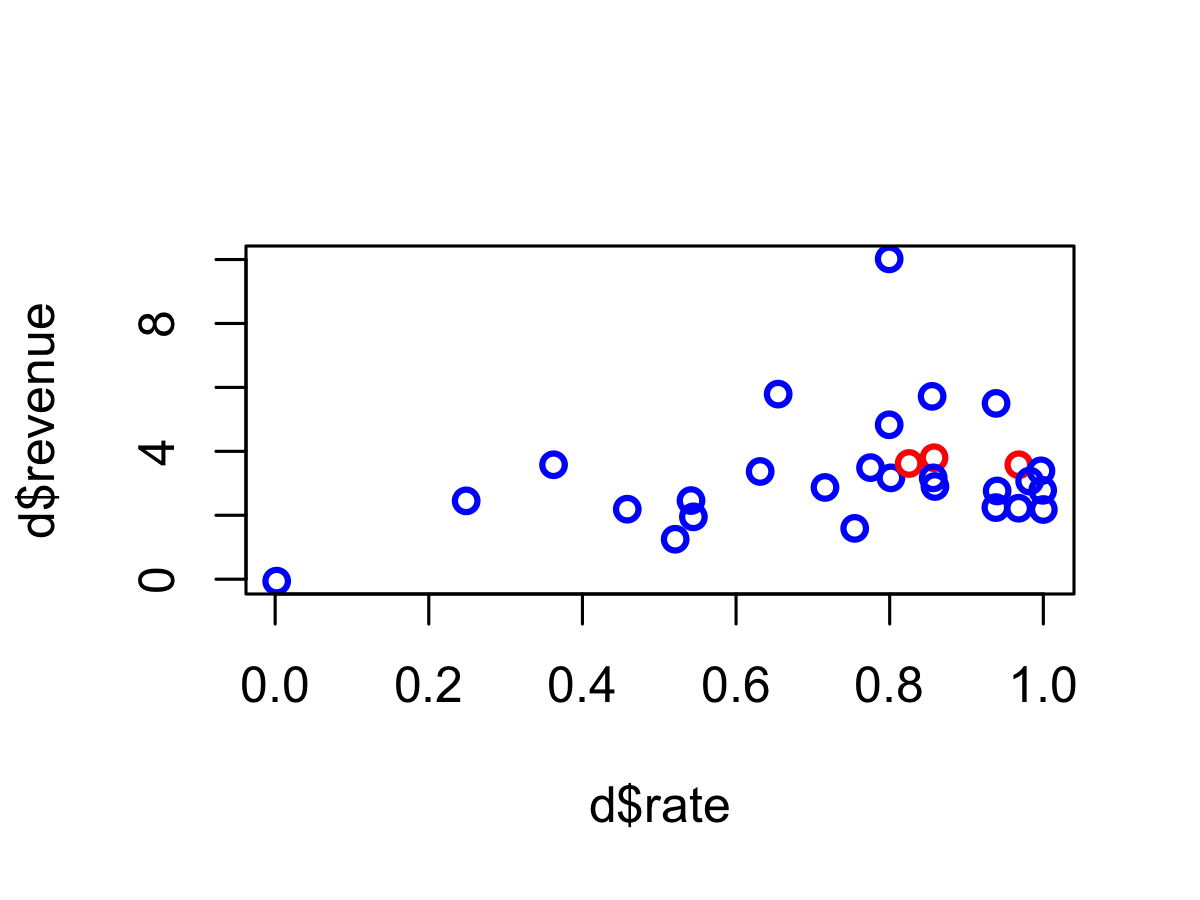

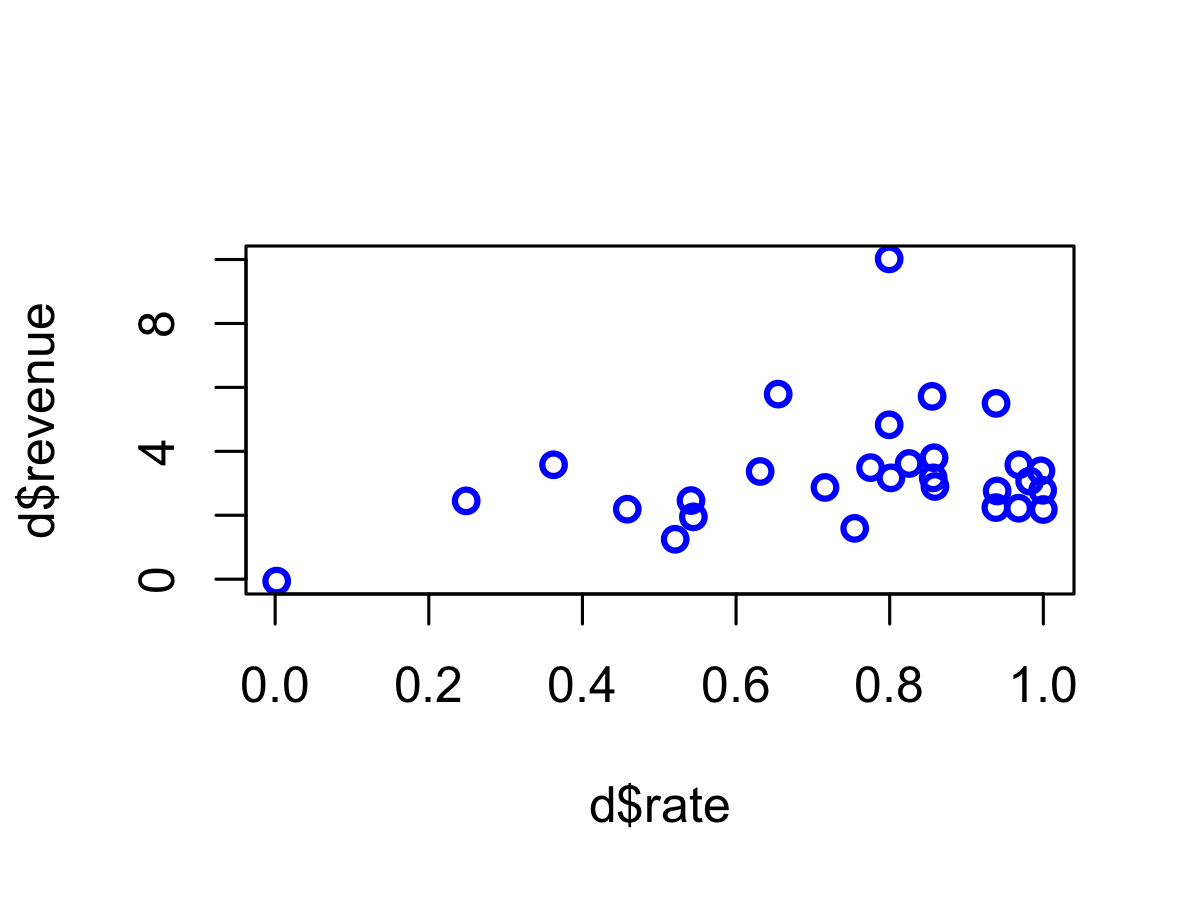

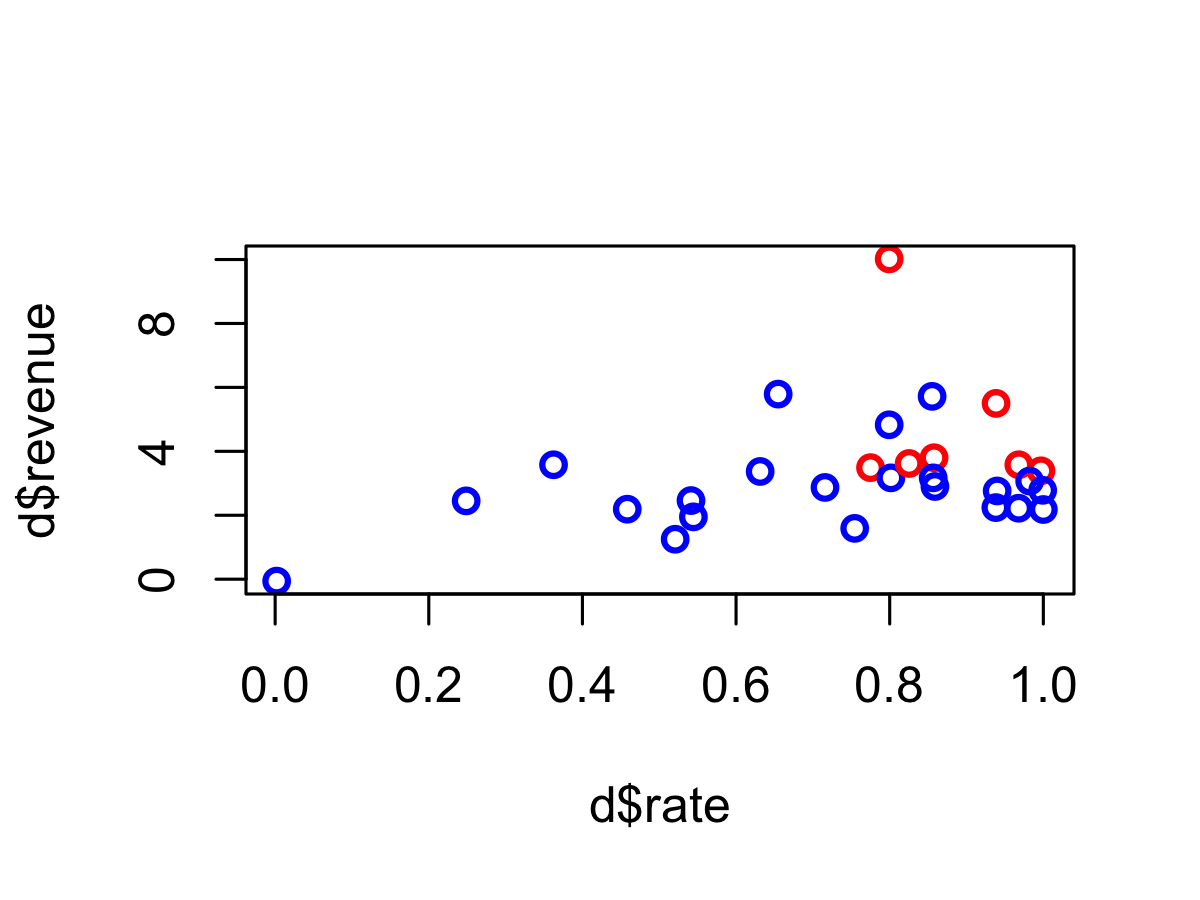

In [277]:
#problematic datapoints for the student's distributed revenues
plot(d$revenue ~ d$rate ,
     col=ifelse(PSIS_line.T$k>=.5, 'red', 'blue') , lwd=2,
     )
plot(d$revenue ~ d$rate ,
     col=ifelse(PSIS_quad.T$k>=.5, 'red', 'blue') , lwd=2,
     )
plot(d$revenue ~ d$rate ,
     col=ifelse(PSIS_cubic.T$k>=.5, 'red', 'blue') , lwd=2,
     )

**t-distributed and gaussian quadratic Model**

In [278]:
rate.seq <- seq( from=0 , to=1 , length.out=30 )
pred_dat <- list( rate=rate.seq ) 
mu <- link( m.quad.T , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )

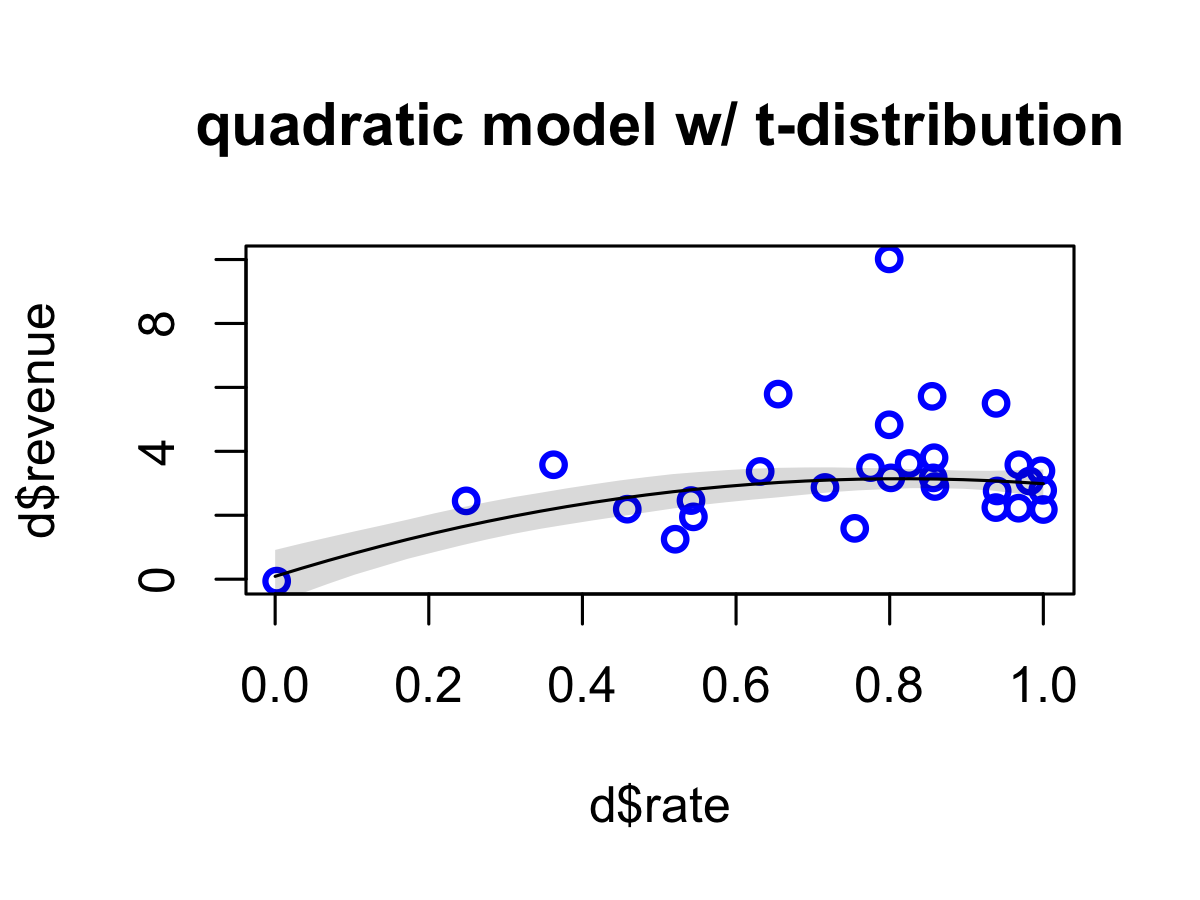

In [279]:
plot( d$revenue ~ d$rate , d , col=ifelse(PSIS_quad.T$k>=.5, 'red', 'blue') , lwd=2,
    main='quadratic model w/ t-distribution') 
lines( rate.seq , mu.mean )
shade( mu.PI , rate.seq )

In [280]:
rate.seq <- seq( from=0 , to=1 , length.out=30 )
pred_dat <- list( rate=rate.seq ) 
mu <- link( m.quad , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )

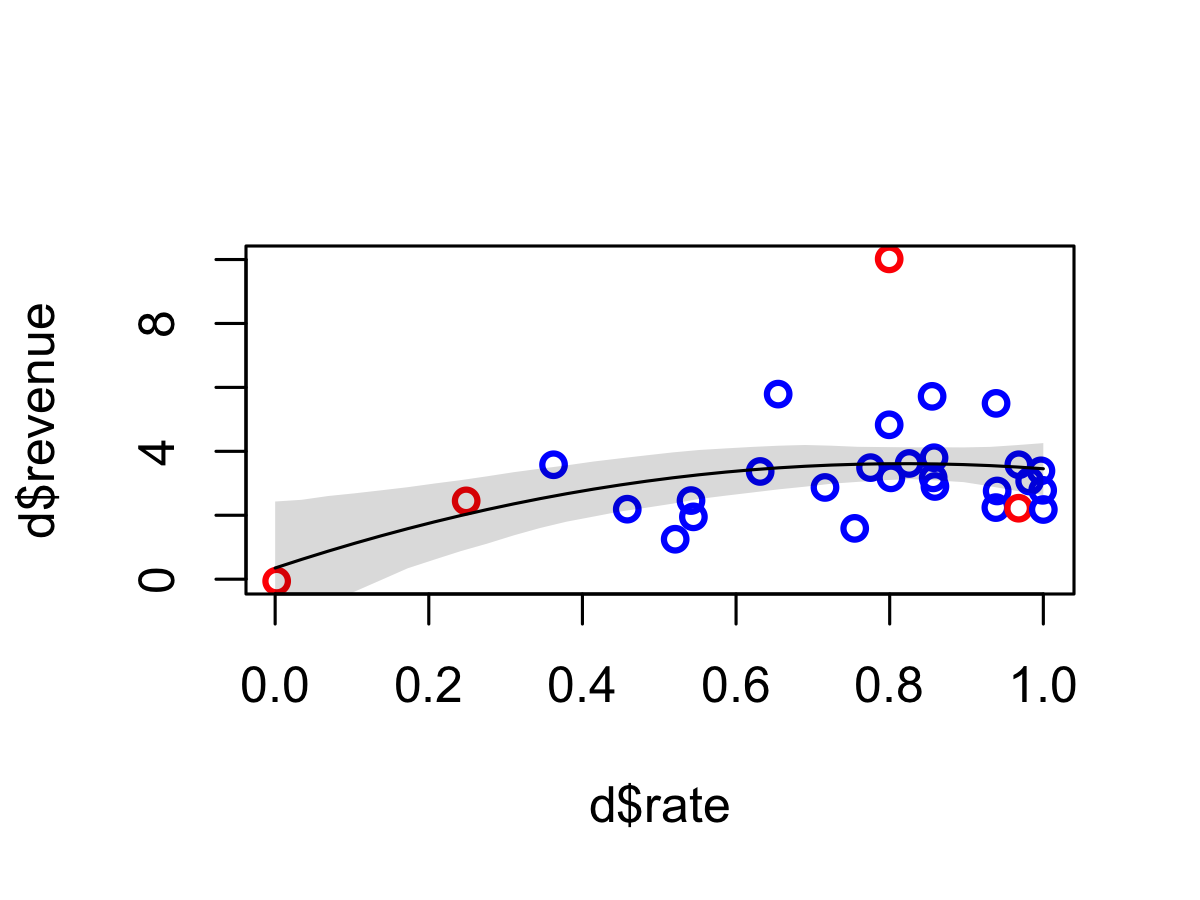

In [281]:
plot( d$revenue ~ d$rate , d , col=ifelse(PSIS_quad$k>=.5, 'red', 'blue') , lwd=2 ) 
lines( rate.seq , mu.mean )
shade( mu.PI , rate.seq )

The most problematic point in the gaussian model had 60 times the penalty of the t-distributed one

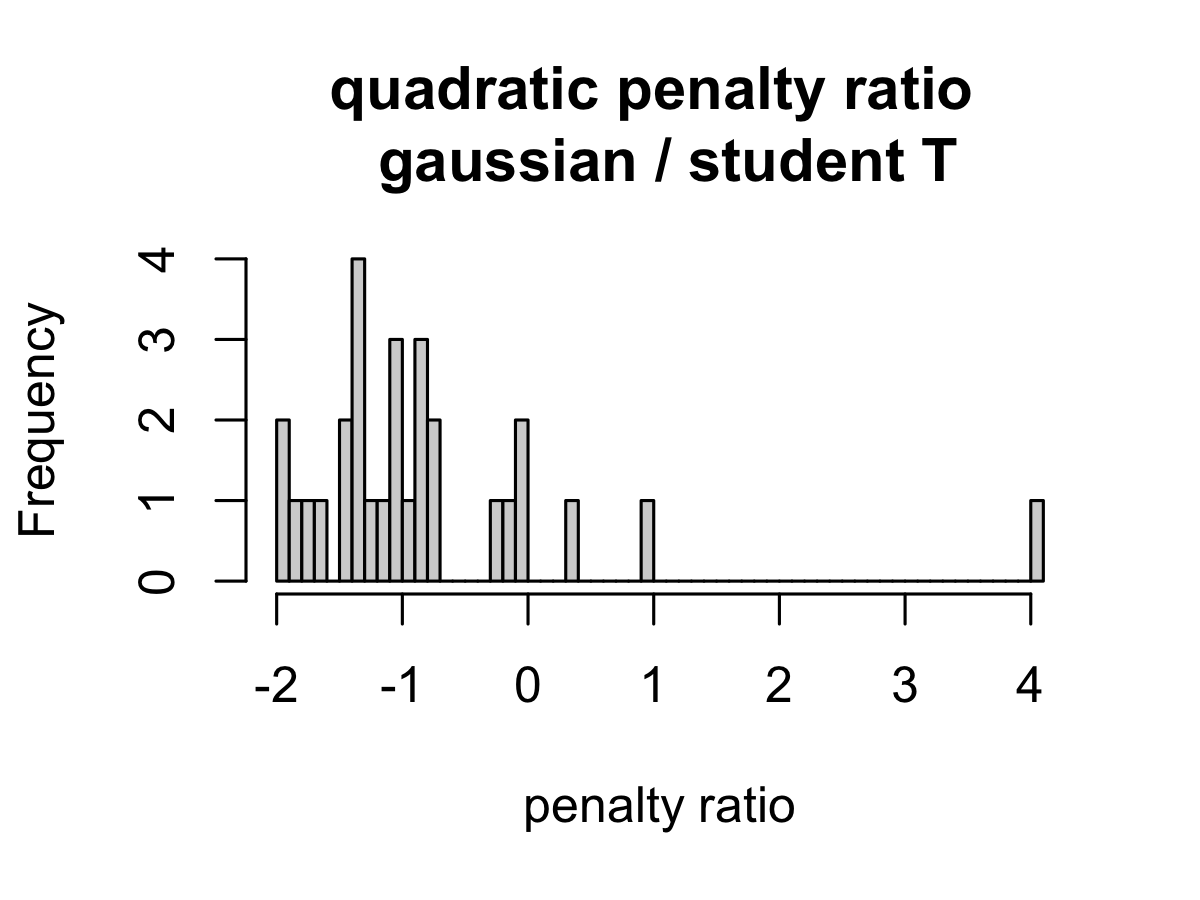

In [282]:
hist(log(PSIS_quad$penalty/PSIS_quad.T$penalty), 
     xlab='penalty ratio', 
     main = "quadratic penalty ratio \n gaussian / student T", breaks=50)

Curves depend a lot on outliers - obviously more and more by increasing their degree, or number of parameters

In [283]:
rate.seq <- seq( from=0 , to=1 , length.out=30 )
pred_dat <- list( rate=rate.seq ) 
mu <- link( m.cubic , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )

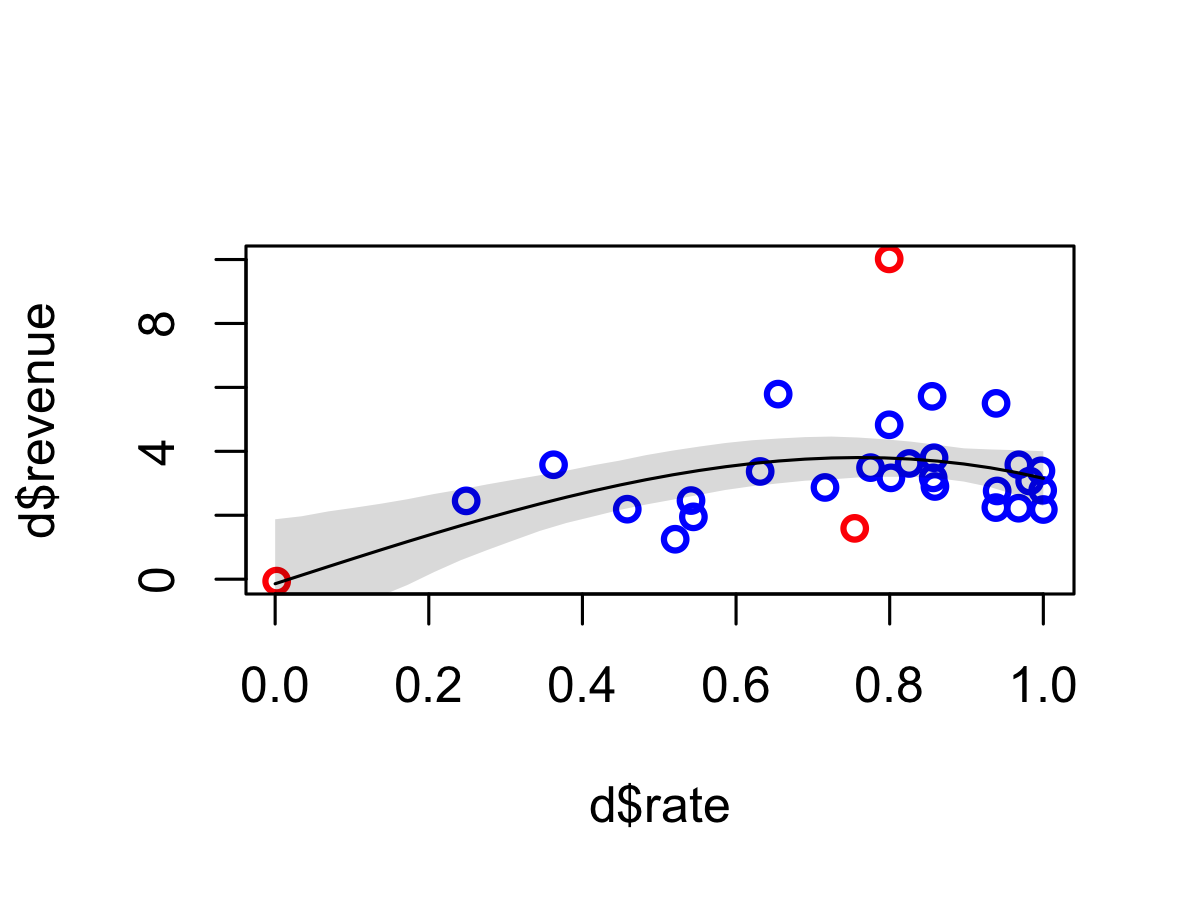

In [284]:
plot( d$revenue ~ d$rate , d , col=ifelse(PSIS_cubic$k>=.5, 'red', 'blue') , lwd=2 ) 
lines( rate.seq , mu.mean )
shade( mu.PI , rate.seq )